In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age', 'sex', 'wrat'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

830
(830, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.2], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [np.stack([ts for ts in filter_design_ts(Xp)]) for Xp in X]
ts = [tsmod/np.linalg.norm(tsmod, axis=(-1), keepdims=True) for tsmod in ts]
print(ts[0].shape)

(830, 264, 124)


In [4]:
import sys

sys.path.append('../../LatentSimilarity')

from latsim import LatSim

print('Complete')

Complete


In [6]:
import itertools
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

class LowRankCodes(nn.Module):
    '''
    ranks: array of rank for each codebook matrix
    '''
    def __init__(self, ranks):
        super(LowRankCodes, self).__init__()
        self.As = []
        for rank in ranks:
            A = nn.Parameter(1e-2*torch.randn(rank,264).float().cuda())
            self.As.append(A)
        self.As = nn.ParameterList(self.As)

    def forward(self):
        book = []
        for A in self.As:
            AA = A.T@A
            book.append(AA)
        return torch.stack(book)
    
class LowRankWeights(nn.Module):
    '''
    For a single modality!
    
    nsubs: number of subjects
    ncodes: number of pages in the codebook
    nt: number of timepoints
    '''
    def __init__(self, nsubs, ncodes, nt):
        super(LowRankWeights, self).__init__()
        self.w = nn.Parameter(1e-2*torch.rand(nsubs, ncodes, nt).float().cuda())

    def forward(self, sub, book):
        w = self.w[sub]
        return torch.einsum('pt,pab->abt', w, book)
    
class MLP(nn.Module):
    def __init__(self, ncodes):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(ncodes, 40).float().cuda()
        self.l2 = nn.Linear(40,1).float().cuda()
        
    def train(self, xtr, ytr, nepochs=1000, lr=1e-1, l1=1e-1, l2=1e-4, pperiod=100, verbose=False):
        optim = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.75, eps=1e-7)
        
        for epoch in range(nepochs):
            optim.zero_grad()
            yhat = self(xtr)
            loss = mseLoss(yhat, ytr)**0.5
            l1loss = l1*torch.sum(torch.abs(self.l1.weight))
            (loss+l1loss).backward()
            optim.step()
            sched.step(loss)
            if verbose:
                if epoch % pperiod == 0 or epoch == nepochs-1:
                    print(f'{epoch} {[float(l) for l in [loss, l1loss]]} {sched._last_lr}')
                    
    def predict(self, xt, yt):
        with torch.no_grad():
            return mseLoss(self(xt), yt)**0.5
                    
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x).squeeze()
        return x
    
def get_recon_loss(x, xhat):
    return mseLoss(xhat, x)

def get_smooth_loss_fc(xhat):
    before = xhat[:,:,:-1]
    after = xhat[:,:,1:]
    return torch.mean((before-after)**2)

def get_sub_fc(subts):
    return torch.einsum('at,bt->abt',subts,subts)

mseLoss = nn.MSELoss()
        
mod = 'rest2emoid'
modidx = 0
modidx2 = 2
    
for ncodes in [10,50,100,200,300,400,500,600,800,1000,1200,1400,1600]:
    for split in range(3):

        # Timeseries
        x = torch.from_numpy(ts[modidx]).float().cuda()
        x2 = torch.from_numpy(ts[modidx2]).float().cuda()

        # Parameters
        ntrain = 400
        nbatch = 30
        smooth_mult = 0.1
        sparse_mult = 0#1e-3
        nEpochs = 60
        pPeriod = 40
        
        print(f'Starting ncodes {ncodes} split {split}')
        suborder = np.arange(x.shape[0])
        np.random.shuffle(suborder)
        suborder = suborder[:ntrain]

        # Codebook and weights
        lrc = LowRankCodes(ncodes*[1])
        lrw = LowRankWeights(ntrain, ncodes, x.shape[-1])

        # Optimizers
        optim = torch.optim.Adam(itertools.chain(lrc.parameters(), lrw.parameters()), lr=1e-2, weight_decay=0)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=int(ntrain/nbatch)+5, factor=0.75, eps=1e-7)

        t0 = time.time()

        for epoch in range(nEpochs):
            for bstart in range(0,ntrain,nbatch):
                bend = bstart+nbatch
                if bend > ntrain:
                    bend = ntrain
                optim.zero_grad()
                book = lrc()
                recon_loss = 0
                smooth_loss_fc = 0
                sparse_loss = 0
                for subidx in range(bstart, bend):
                    # THE FOLLOWING 3 LINES MEAN LRW.W DOESN'T MATCH SUBJECTS UNLESS WE MAP THROUGH SUBORDER
                    # WHICH IS OKAY SINCE WE RE-ESTIMATE WEIGHTS THROUGH THE DICTIONARY ANYWAY
                    sub = suborder[subidx]
                    xsub = get_sub_fc(x[sub])
                    xhat = lrw(subidx, book)       
                    recon_loss += get_recon_loss(xsub, xhat)
                    smooth_loss_fc += smooth_mult*get_smooth_loss_fc(xhat)
                recon_loss /= (bend-bstart)
                smooth_loss_fc /= (bend-bstart)
#                 sparse_loss = sparse_mult*torch.mean(torch.abs(lrw.w))
        #         sparse_loss = sparse_mult*torch.mean(lrw.w*torch.log(lrw.w))
                totloss = recon_loss+smooth_loss_fc+sparse_loss
                totloss.backward()
                optim.step()
                sched.step(totloss)
            if epoch % 5 == 0 or epoch == nEpochs-1:
                print(f'{epoch} {bstart} recon: {[float(ls)**0.5 for ls in [recon_loss, smooth_loss_fc, sparse_loss]]} '
                      f'lr: {sched._last_lr}')

        t1 = time.time()
        print(f'Completed dictionary estimation {t1-t0} sec')
        
        # Weight estimation
        book = lrc()

        A = book.reshape(book.shape[0], -1).permute(1,0)
        AA = A.T@A
        codes = []

        for sub in range(x2.shape[0]):
            B = get_sub_fc(x2[sub]).reshape(-1, x2.shape[-1])
            AB = A.T@B
            C,_,_,_ = torch.linalg.lstsq(AA+0.1*torch.eye(AA.shape[0]).float().cuda(),AB)
            codes.append(torch.from_numpy(C.detach().cpu().numpy()))
            if sub % 100 == 0:
                loss = mseLoss(A@C,B)**0.5
                print(f'Finished {sub} {loss}')

        codes = torch.stack(codes)
        print(codes.shape)
        print('Finished weight estimation')
        
        trainsizes = [30,50,100,200,300,400,500,600,700,800]
        nreps = 10
        
        # Lstsq
        res = np.zeros((nreps,len(trainsizes)))
        l2 = 1e-2

        for rep in range(nreps):
            losses = []

            idcs = np.arange(codes.shape[0])
            np.random.shuffle(idcs)

            for ntrain in trainsizes:
                codescuda = codes.float().cuda()
                xps = torch.mean(codescuda, dim=-1)
                xps = torch.cat([xps, torch.ones(xps.shape[0], 1).float().cuda()], dim=1)
                xtr = xps[idcs[:ntrain]]
                xt = xps[idcs[ntrain:]]

                y = get_y(metadict, ['age'], subs)[0]
                y_t = torch.from_numpy(y).float().cuda()
                ytr = y_t[idcs[:ntrain]]
                yt = y_t[idcs[ntrain:]]

                # REDUCE THIS TO GET GOOD RESULTS WITH SPARSITY 0.01->0.001 or 0.0001
                w, _, _, _ = torch.linalg.lstsq(xtr.T@xtr + l2*torch.eye(ncodes+1).float().cuda(), xtr.T@ytr)

                print(torch.mean((yt-xt@w)**2)**0.5)
                losses.append(float(torch.mean((yt-xt@w)**2)**0.5))

            print(f'Finished {rep}')
            res[rep,:] = losses
            
        with open(f'/home/anton/Documents/Tulane/Research/Work/LatSimEC2/DictEst/{mod}-lstsq-mean.csv', 
                  'a') as f:
            f.write(f'{ncodes},{split},{",".join([str(val) for val in np.mean(res, axis=0)])}\n')
            
        with open(f'/home/anton/Documents/Tulane/Research/Work/LatSimEC2/DictEst/{mod}-lstsq-std.csv', 
                  'a') as f:
            f.write(f'{ncodes},{split},{",".join([str(val) for val in np.std(res, axis=0)])}\n')
        
        print(f'Finished lstsq')
        
        # MLP
        res = np.zeros((nreps,len(trainsizes)))

        for rep in range(nreps):

            idcs = np.arange(codes.shape[0])
            np.random.shuffle(idcs)

            losses = []

            for ntrain in trainsizes:
                codescuda = codes.float().cuda()
                xps = torch.mean(codescuda, dim=-1)
                xtr = xps[idcs[:ntrain]]
                xt = xps[idcs[ntrain:]]

                y = get_y(metadict, ['age'], subs)[0]
                y_t = torch.from_numpy(y).float().cuda()
                ytr = y_t[idcs[:ntrain]]
                yt = y_t[idcs[ntrain:]]

                mlp = MLP(ncodes)
                # 1e-3 good for age 1e-2 good for wrat
                mlp.train(xtr, ytr, lr=1e-2, nepochs=1000, l1=1e-3, l2=1e-4)
                loss = mlp.predict(xt, yt)

                losses.append(float(loss))
                print(float(loss))

            res[rep,:] = losses
            print(f'Finished {rep}')

        with open(f'/home/anton/Documents/Tulane/Research/Work/LatSimEC2/DictEst/{mod}-mlp-mean.csv', 
                  'a') as f:
            f.write(f'{ncodes},{split},{",".join([str(val) for val in np.mean(res, axis=0)])}\n')
            
        with open(f'/home/anton/Documents/Tulane/Research/Work/LatSimEC2/DictEst/{mod}-mlp-std.csv', 
                  'a') as f:
            f.write(f'{ncodes},{split},{",".join([str(val) for val in np.std(res, axis=0)])}\n')
            
        print(f'Finished mlp')
        
        # LatSim
        res = np.zeros((nreps,len(trainsizes)))

        nepochs = 500
        pperiod = 100
        verbose = False

        for rep in range(nreps):

            idcs = np.arange(codes.shape[0])
            np.random.shuffle(idcs)

            losses = []

            for ntrain in trainsizes:
                codescuda = codes.float().cuda()
                xps = torch.mean(codescuda[idcs], dim=-1).unsqueeze(1)

                mu = torch.mean(xps[:ntrain], dim=0, keepdims=True)
                std = torch.std(xps[:ntrain], dim=0, keepdims=True)
                xps = (xps-mu)/std

                xtr = xps[:ntrain]
                xt = xps[ntrain:]

                y = get_y(metadict, ['age'], subs)[0]
                y_t = torch.from_numpy(y[idcs]).float().cuda()
                ytr = y_t[:ntrain]
                yt = y_t[ntrain:]

                # dp=0.5 for wrat
                sim = LatSim(1, xps, dp=0.5, edp=0.1, wInit=1e-4, dim=2, temp=1)
                optim = torch.optim.Adam(sim.parameters(), lr=1e-3, weight_decay=1e-3)
                sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.75, eps=1e-7)

                for epoch in range(nepochs):
                    optim.zero_grad()
                    yhat = sim(xtr, [ytr])[0][0]
                    loss = mseLoss(yhat, ytr)**0.5
                    loss.backward()
                    optim.step()
                    sched.step(loss)
                    if verbose:
                        if epoch % pperiod == 0 or epoch == nepochs-1:
                            print(f'{epoch} {float(loss)} {sched._last_lr}')

                sim.eval()
                yhat = sim(xps, [y_t], np.arange(ntrain,idcs.shape[0]))[0][0][ntrain:]
                loss = mseLoss(yhat, yt)**0.5
                losses.append(float(loss))

                print(float(loss))

            res[rep,:] = losses
            print(f'Finished {rep}')
        
        with open(f'/home/anton/Documents/Tulane/Research/Work/LatSimEC2/DictEst/{mod}-latsim-mean.csv', 
                  'a') as f:
            f.write(f'{ncodes},{split},{",".join([str(val) for val in np.mean(res, axis=0)])}\n')
            
        with open(f'/home/anton/Documents/Tulane/Research/Work/LatSimEC2/DictEst/{mod}-latsim-std.csv', 
                  'a') as f:
            f.write(f'{ncodes},{split},{",".join([str(val) for val in np.std(res, axis=0)])}\n')
            
        print(f'Finished LatSim')

Starting ncodes 10 split 0
0 390 recon: [0.011704962661531084, 4.628421678035866e-07, 0.0] lr: [0.01]
5 390 recon: [0.012031234054779348, 0.0022336048084485344, 0.0] lr: [0.0075]
10 390 recon: [0.009822573611747643, 0.0016822739928590822, 0.0] lr: [0.00421875]
15 390 recon: [0.009653332060366338, 0.001926116635868701, 0.0] lr: [0.0031640625]
20 390 recon: [0.009383790466536958, 0.0020368723087832064, 0.0] lr: [0.0031640625]
25 390 recon: [0.009127205500739947, 0.0018487317306217115, 0.0] lr: [0.002373046875]
30 390 recon: [0.009056558894207567, 0.0018710223035914699, 0.0] lr: [0.0017797851562500002]
35 390 recon: [0.00901805043359815, 0.0019147503406877972, 0.0] lr: [0.0017797851562500002]
40 390 recon: [0.009005914125351571, 0.001994300599901691, 0.0] lr: [0.0013348388671875003]
45 390 recon: [0.008938157242295755, 0.0019319066144528653, 0.0] lr: [0.0013348388671875003]
50 390 recon: [0.008949094820834778, 0.002024542984909179, 0.0] lr: [0.0013348388671875003]
55 390 recon: [0.0089911

36.76809310913086
37.73361587524414
38.16522979736328
46.59150314331055
Finished 6
39.50962448120117
38.34077835083008
38.93756103515625
37.53590393066406
38.15953063964844
38.97890853881836
39.51283645629883
39.56680679321289
40.62350082397461
42.624610900878906
Finished 7
38.06871795654297
37.766239166259766
39.02262496948242
37.85675811767578
38.074310302734375
38.92485427856445
39.553489685058594
40.46554183959961
40.85935592651367
43.522926330566406
Finished 8
39.35708236694336
39.2901725769043
39.387996673583984
38.98890686035156
39.73602294921875
38.76454162597656
39.32946014404297
38.21819305419922
38.27659606933594
38.745296478271484
Finished 9
Finished LatSim
Starting ncodes 10 split 1
0 390 recon: [0.012587774429162327, 4.610468877550317e-07, 0.0] lr: [0.01]
5 390 recon: [0.01320012202249235, 0.002835842425826798, 0.0] lr: [0.0075]
10 390 recon: [0.010728616839394474, 0.002013903659325294, 0.0] lr: [0.0075]
15 390 recon: [0.010306471600496567, 0.0018990076194340421, 0.0] lr:

37.765811920166016
37.299625396728516
35.132102966308594
39.646583557128906
Finished 3
38.90622329711914
37.869693756103516
38.28053665161133
38.74736404418945
37.82355499267578
36.42211151123047
36.3239631652832
36.018035888671875
36.241127014160156
35.15708923339844
Finished 4
38.43954849243164
38.48629379272461
38.11280822753906
36.748172760009766
37.37165069580078
37.44666290283203
36.57172393798828
38.094356536865234
38.70652389526367
40.58372116088867
Finished 5
39.064456939697266
38.841495513916016
38.64160919189453
37.713966369628906
38.02076721191406
37.935516357421875
36.91144561767578
36.19648361206055
36.05016326904297
31.785226821899414
Finished 6
39.840538024902344
39.72550964355469
39.871829986572266
39.21900177001953
38.31814956665039
37.147987365722656
37.48042297363281
38.02893829345703
39.586463928222656
39.698997497558594
Finished 7
37.4859504699707
37.672847747802734
37.812469482421875
37.2633171081543
37.371788024902344
36.81840896606445
36.99919128417969
35.38346

39.29360580444336
39.15181350708008
38.60177993774414
37.771453857421875
38.47211456298828
39.3694953918457
39.05048751831055
38.841068267822266
32.67484664916992
Finished 0
39.05072784423828
38.84273910522461
39.125003814697266
38.226356506347656
37.19004440307617
37.10012435913086
36.94382095336914
37.523075103759766
38.93979263305664
35.08877182006836
Finished 1
39.85149002075195
40.15044021606445
37.41814422607422
37.53519821166992
38.2578125
37.445186614990234
38.34541702270508
38.797969818115234
40.274208068847656
41.839141845703125
Finished 2
39.267066955566406
39.26901626586914
39.03007125854492
38.49879837036133
38.19645690917969
38.5198860168457
38.175750732421875
39.01838684082031
39.37798309326172
36.090423583984375
Finished 3
40.013328552246094
39.96368408203125
39.56606674194336
38.96717834472656
38.822566986083984
39.0426139831543
38.73291015625
38.77557373046875
37.90703582763672
42.117130279541016
Finished 4
39.05702209472656
39.98813247680664
39.46937942504883
39.0067

37.147010803222656
38.32034683227539
37.54917526245117
31.508602142333984
Finished 6
41.619842529296875
39.20133590698242
38.775230407714844
36.312347412109375
35.774288177490234
35.89872741699219
34.144081115722656
34.30857849121094
35.19608688354492
33.75208282470703
Finished 7
38.268531799316406
35.768489837646484
35.58367919921875
35.30560302734375
34.925758361816406
34.62734603881836
34.6303596496582
35.34000015258789
35.777809143066406
36.31523132324219
Finished 8
37.24822235107422
37.568206787109375
35.97312927246094
34.737831115722656
34.576820373535156
35.284732818603516
35.05909729003906
35.56239700317383
35.05854415893555
36.699424743652344
Finished 9
Finished mlp
36.61923599243164
36.95582962036133
34.34521484375
34.288185119628906
34.73853302001953
34.27302169799805
34.041717529296875
33.56909942626953
34.33295822143555
38.317440032958984
Finished 0
39.40220260620117
37.06208038330078
35.852413177490234
35.543418884277344
35.06412124633789
34.60420227050781
34.391838073730

37.67425537109375
37.42459487915039
37.57592010498047
36.68624496459961
36.7848014831543
36.367305755615234
35.766292572021484
30.41603660583496
Finished 3
39.03129577636719
37.27726364135742
38.091575622558594
37.748897552490234
38.82185363769531
38.46561050415039
38.340572357177734
38.50955581665039
37.91822814941406
40.89665603637695
Finished 4
38.56258773803711
37.652870178222656
38.00655746459961
38.21809387207031
37.52644729614258
38.78261947631836
38.86687088012695
38.83293533325195
40.464820861816406
40.627620697021484
Finished 5
40.162132263183594
38.90290069580078
38.89260482788086
37.64475631713867
37.420040130615234
38.13446044921875
38.137176513671875
37.94728088378906
37.70737838745117
35.042625427246094
Finished 6
39.85753631591797
38.75758743286133
37.666717529296875
37.23783874511719
37.410396575927734
36.61796188354492
36.88058853149414
37.649864196777344
36.43724822998047
34.315006256103516
Finished 7
41.343502044677734
40.42709732055664
38.67020797729492
37.98542785

38.2382926940918
38.583614349365234
38.10932540893555
38.067440032958984
38.38484573364258
38.11038589477539
37.54391098022461
37.042823791503906
37.912654876708984
40.03226852416992
Finished 0
40.5423698425293
36.91743469238281
36.534202575683594
36.581661224365234
36.83708190917969
37.12094497680664
39.05978012084961
37.51737976074219
40.00115966796875
41.028682708740234
Finished 1
38.70925521850586
36.051414489746094
36.83252716064453
38.2392578125
38.627098083496094
37.18541717529297
37.44388198852539
38.58024597167969
38.93813705444336
41.35262680053711
Finished 2
35.735923767089844
36.679229736328125
37.00563430786133
36.841835021972656
37.67503356933594
37.819156646728516
38.2651252746582
37.92210006713867
38.516693115234375
36.66374969482422
Finished 3
36.18631362915039
36.35646057128906
37.52706527709961
37.267127990722656
37.144073486328125
37.625301361083984
37.44786834716797
36.84613800048828
35.42534637451172
35.821937561035156
Finished 4
37.10498809814453
38.0879974365234

tensor(36.3533, device='cuda:0')
tensor(36.2656, device='cuda:0')
tensor(34.8983, device='cuda:0')
tensor(34.5275, device='cuda:0')
tensor(33.1562, device='cuda:0')
tensor(33.9166, device='cuda:0')
tensor(37.9658, device='cuda:0')
Finished 8
tensor(38.5951, device='cuda:0')
tensor(38.3010, device='cuda:0')
tensor(38.2320, device='cuda:0')
tensor(36.5765, device='cuda:0')
tensor(34.9698, device='cuda:0')
tensor(34.4867, device='cuda:0')
tensor(35.2787, device='cuda:0')
tensor(34.1097, device='cuda:0')
tensor(33.6375, device='cuda:0')
tensor(28.5988, device='cuda:0')
Finished 9
Finished lstsq
36.09291076660156
37.091766357421875
36.74905014038086
36.61867904663086
37.715965270996094
36.79838943481445
37.88373947143555
38.23075866699219
38.35165786743164
35.79717254638672
Finished 0
37.95073318481445
39.11960220336914
37.75861740112305
37.85149383544922
36.63655471801758
36.6043701171875
35.81357192993164
36.81962585449219
35.75490188598633
36.79277801513672
Finished 1
36.3096809387207
35

tensor(36.7391, device='cuda:0')
tensor(35.5772, device='cuda:0')
tensor(34.4738, device='cuda:0')
tensor(33.5804, device='cuda:0')
tensor(32.3923, device='cuda:0')
tensor(32.7856, device='cuda:0')
tensor(32.4643, device='cuda:0')
tensor(37.6533, device='cuda:0')
Finished 7
tensor(40.4144, device='cuda:0')
tensor(40.9740, device='cuda:0')
tensor(38.0718, device='cuda:0')
tensor(35.5617, device='cuda:0')
tensor(34.9012, device='cuda:0')
tensor(34.5394, device='cuda:0')
tensor(34.1861, device='cuda:0')
tensor(34.2242, device='cuda:0')
tensor(31.9372, device='cuda:0')
tensor(32.8930, device='cuda:0')
Finished 8
tensor(37.3816, device='cuda:0')
tensor(36.8329, device='cuda:0')
tensor(36.0650, device='cuda:0')
tensor(34.7959, device='cuda:0')
tensor(34.4215, device='cuda:0')
tensor(34.9801, device='cuda:0')
tensor(34.6475, device='cuda:0')
tensor(34.4293, device='cuda:0')
tensor(34.0782, device='cuda:0')
tensor(39.0536, device='cuda:0')
Finished 9
Finished lstsq
37.87451171875
37.1670036315

tensor(38.0837, device='cuda:0')
Finished 5
tensor(38.7137, device='cuda:0')
tensor(38.6083, device='cuda:0')
tensor(37.2969, device='cuda:0')
tensor(35.7461, device='cuda:0')
tensor(34.3618, device='cuda:0')
tensor(33.6772, device='cuda:0')
tensor(33.3342, device='cuda:0')
tensor(32.6488, device='cuda:0')
tensor(30.8188, device='cuda:0')
tensor(31.8663, device='cuda:0')
Finished 6
tensor(39.0027, device='cuda:0')
tensor(38.3848, device='cuda:0')
tensor(36.9249, device='cuda:0')
tensor(36.6827, device='cuda:0')
tensor(35.6994, device='cuda:0')
tensor(34.5861, device='cuda:0')
tensor(34.1122, device='cuda:0')
tensor(33.7459, device='cuda:0')
tensor(33.8020, device='cuda:0')
tensor(25.9662, device='cuda:0')
Finished 7
tensor(38.1451, device='cuda:0')
tensor(38.3156, device='cuda:0')
tensor(38.2435, device='cuda:0')
tensor(37.0554, device='cuda:0')
tensor(35.6828, device='cuda:0')
tensor(35.3350, device='cuda:0')
tensor(34.7024, device='cuda:0')
tensor(33.2571, device='cuda:0')
tensor(30.

tensor(31.9886, device='cuda:0')
tensor(31.3300, device='cuda:0')
tensor(30.2185, device='cuda:0')
tensor(30.5969, device='cuda:0')
tensor(30.9855, device='cuda:0')
tensor(36.4318, device='cuda:0')
Finished 4
tensor(37.3302, device='cuda:0')
tensor(36.2236, device='cuda:0')
tensor(35.1060, device='cuda:0')
tensor(34.9050, device='cuda:0')
tensor(33.4104, device='cuda:0')
tensor(32.6310, device='cuda:0')
tensor(32.0622, device='cuda:0')
tensor(31.5535, device='cuda:0')
tensor(30.3752, device='cuda:0')
tensor(26.6771, device='cuda:0')
Finished 5
tensor(38.1804, device='cuda:0')
tensor(36.9648, device='cuda:0')
tensor(36.8151, device='cuda:0')
tensor(34.7649, device='cuda:0')
tensor(32.5898, device='cuda:0')
tensor(32.6460, device='cuda:0')
tensor(32.5165, device='cuda:0')
tensor(31.7750, device='cuda:0')
tensor(31.3578, device='cuda:0')
tensor(30.1467, device='cuda:0')
Finished 6
tensor(40.1966, device='cuda:0')
tensor(36.9966, device='cuda:0')
tensor(35.0106, device='cuda:0')
tensor(34.

tensor(33.0943, device='cuda:0')
tensor(35.0186, device='cuda:0')
Finished 2
tensor(40.1216, device='cuda:0')
tensor(38.2534, device='cuda:0')
tensor(36.2843, device='cuda:0')
tensor(34.5823, device='cuda:0')
tensor(33.2362, device='cuda:0')
tensor(32.7589, device='cuda:0')
tensor(31.9815, device='cuda:0')
tensor(31.7078, device='cuda:0')
tensor(30.8361, device='cuda:0')
tensor(26.5220, device='cuda:0')
Finished 3
tensor(38.9661, device='cuda:0')
tensor(37.5099, device='cuda:0')
tensor(36.2910, device='cuda:0')
tensor(34.4159, device='cuda:0')
tensor(33.7230, device='cuda:0')
tensor(32.6696, device='cuda:0')
tensor(32.2258, device='cuda:0')
tensor(30.4014, device='cuda:0')
tensor(32.4328, device='cuda:0')
tensor(30.0037, device='cuda:0')
Finished 4
tensor(37.7416, device='cuda:0')
tensor(36.6190, device='cuda:0')
tensor(35.7056, device='cuda:0')
tensor(34.0187, device='cuda:0')
tensor(33.1264, device='cuda:0')
tensor(32.2986, device='cuda:0')
tensor(32.0665, device='cuda:0')
tensor(31.

tensor(32.7003, device='cuda:0')
tensor(31.5302, device='cuda:0')
tensor(31.5711, device='cuda:0')
tensor(35.5796, device='cuda:0')
Finished 1
tensor(37.8836, device='cuda:0')
tensor(37.7477, device='cuda:0')
tensor(35.4940, device='cuda:0')
tensor(35.0434, device='cuda:0')
tensor(33.2151, device='cuda:0')
tensor(33.7073, device='cuda:0')
tensor(32.8441, device='cuda:0')
tensor(32.1948, device='cuda:0')
tensor(31.8936, device='cuda:0')
tensor(35.4500, device='cuda:0')
Finished 2
tensor(40.1135, device='cuda:0')
tensor(37.9241, device='cuda:0')
tensor(37.2603, device='cuda:0')
tensor(35.6766, device='cuda:0')
tensor(34.2975, device='cuda:0')
tensor(33.7610, device='cuda:0')
tensor(33.1127, device='cuda:0')
tensor(31.4029, device='cuda:0')
tensor(29.7901, device='cuda:0')
tensor(28.0770, device='cuda:0')
Finished 3
tensor(38.2724, device='cuda:0')
tensor(37.2245, device='cuda:0')
tensor(36.1457, device='cuda:0')
tensor(34.0061, device='cuda:0')
tensor(32.9625, device='cuda:0')
tensor(32.

Finished 800 0.0036534578539431095
torch.Size([830, 300, 210])
Finished weight estimation
tensor(38.8574, device='cuda:0')
tensor(37.9085, device='cuda:0')
tensor(36.3411, device='cuda:0')
tensor(33.8189, device='cuda:0')
tensor(33.5092, device='cuda:0')
tensor(32.1981, device='cuda:0')
tensor(31.1083, device='cuda:0')
tensor(30.3802, device='cuda:0')
tensor(31.5721, device='cuda:0')
tensor(35.6012, device='cuda:0')
Finished 0
tensor(40.6704, device='cuda:0')
tensor(37.7949, device='cuda:0')
tensor(35.1785, device='cuda:0')
tensor(33.1875, device='cuda:0')
tensor(32.7841, device='cuda:0')
tensor(32.2425, device='cuda:0')
tensor(30.5133, device='cuda:0')
tensor(30.3111, device='cuda:0')
tensor(29.2272, device='cuda:0')
tensor(23.6937, device='cuda:0')
Finished 1
tensor(37.0857, device='cuda:0')
tensor(37.0417, device='cuda:0')
tensor(35.5587, device='cuda:0')
tensor(33.9334, device='cuda:0')
tensor(32.8044, device='cuda:0')
tensor(32.2159, device='cuda:0')
tensor(31.2690, device='cuda:0

50 390 recon: [0.008844912588581466, 0.004382758879423866, 0.0] lr: [0.00421875]
55 390 recon: [0.008275330933680151, 0.004085463524024919, 0.0] lr: [0.00421875]
59 390 recon: [0.008744150305443978, 0.004463523257706056, 0.0] lr: [0.00421875]
Completed dictionary estimation 277.14025950431824 sec
Finished 0 0.003914053551852703
Finished 100 0.005818247329443693
Finished 200 0.003966199699789286
Finished 300 0.004490198567509651
Finished 400 0.006118600722402334
Finished 500 0.00432403851300478
Finished 600 0.004279022570699453
Finished 700 0.004521506372839212
Finished 800 0.0036508855409920216
torch.Size([830, 300, 210])
Finished weight estimation
tensor(39.1568, device='cuda:0')
tensor(38.8151, device='cuda:0')
tensor(36.8620, device='cuda:0')
tensor(34.4764, device='cuda:0')
tensor(32.0714, device='cuda:0')
tensor(31.8095, device='cuda:0')
tensor(30.8735, device='cuda:0')
tensor(31.2653, device='cuda:0')
tensor(31.3103, device='cuda:0')
tensor(27.1934, device='cuda:0')
Finished 0
te

15 390 recon: [0.01102252104710212, 0.005103885857044789, 0.0] lr: [0.0075]
20 390 recon: [0.009158375929628693, 0.0036992936995953814, 0.0] lr: [0.0075]
25 390 recon: [0.007398011581303325, 0.0024279404670959487, 0.0] lr: [0.005625]
30 390 recon: [0.007055406602861247, 0.0025703462835355113, 0.0] lr: [0.005625]
35 390 recon: [0.006959079045100903, 0.0026224616618776737, 0.0] lr: [0.0031640625]
40 390 recon: [0.006868817399879622, 0.002744259945442709, 0.0] lr: [0.002373046875]
45 390 recon: [0.006712425142091182, 0.0026272861999548478, 0.0] lr: [0.0017797851562500002]
50 390 recon: [0.006662365498120157, 0.002635690983554144, 0.0] lr: [0.0017797851562500002]
55 390 recon: [0.0066137519429058525, 0.002647931652918252, 0.0] lr: [0.0017797851562500002]
59 390 recon: [0.006660688370184323, 0.002748506173367787, 0.0] lr: [0.0010011291503906252]
Completed dictionary estimation 276.77826499938965 sec
Finished 0 0.0038553758058696985
Finished 100 0.005595340859144926
Finished 200 0.0039248764

35.35532760620117
34.315616607666016
32.20342254638672
31.418277740478516
30.27424430847168
29.00189971923828
29.338214874267578
28.846878051757812
30.09844207763672
34.893707275390625
Finished 8
35.19225311279297
32.09954833984375
32.158546447753906
31.58057975769043
30.76232147216797
29.076583862304688
29.11821937561035
28.13144302368164
29.286113739013672
32.39093017578125
Finished 9
Finished LatSim
Starting ncodes 400 split 0
0 390 recon: [0.013471740982279856, 3.0847033161532724e-06, 0.0] lr: [0.01]
5 390 recon: [0.013079043808182011, 0.004491895322458859, 0.0] lr: [0.01]
10 390 recon: [0.009151636036868385, 0.0030723613872077698, 0.0] lr: [0.01]
15 390 recon: [0.009189192801035377, 0.003553201989841724, 0.0] lr: [0.0075]
20 390 recon: [0.014111182907538655, 0.007604499253651467, 0.0] lr: [0.0075]
25 390 recon: [0.00747206133490181, 0.0033814217093687017, 0.0] lr: [0.005625]
30 390 recon: [0.007359497717379127, 0.003541769101332477, 0.0] lr: [0.005625]
35 390 recon: [0.00752360552

25.242399215698242
21.77366065979004
Finished 4
37.3995361328125
36.478485107421875
31.969268798828125
30.69931983947754
29.861167907714844
27.819456100463867
27.69123649597168
27.56586265563965
29.870649337768555
25.925443649291992
Finished 5
37.61819839477539
33.22916793823242
32.751251220703125
29.968002319335938
29.75141716003418
28.069581985473633
27.42981719970703
27.36834144592285
29.08867073059082
25.743574142456055
Finished 6
41.67706298828125
36.68361282348633
33.34962463378906
31.50629997253418
30.399063110351562
29.632768630981445
28.868045806884766
27.91512107849121
27.756032943725586
28.686437606811523
Finished 7
39.37380599975586
38.15178680419922
33.79741668701172
31.779720306396484
29.890806198120117
29.112646102905273
27.682798385620117
27.30670738220215
28.18332862854004
29.820959091186523
Finished 8
36.1602783203125
34.277381896972656
32.986507415771484
30.995649337768555
29.586669921875
28.9027099609375
27.833980560302734
26.290895462036133
26.646852493286133
21.86

28.066131591796875
28.324228286743164
25.601512908935547
30.42683982849121
Finished 1
36.66627502441406
35.64218521118164
32.35627365112305
30.5130558013916
29.577377319335938
29.580446243286133
28.51888656616211
27.892000198364258
30.610944747924805
31.323925018310547
Finished 2
37.15701675415039
34.746822357177734
32.42377853393555
29.668167114257812
28.46503448486328
28.120454788208008
27.999853134155273
28.509641647338867
26.092178344726562
28.970712661743164
Finished 3
34.93694305419922
34.09337615966797
32.33845901489258
30.211639404296875
28.75983428955078
27.714139938354492
28.355274200439453
29.652833938598633
28.078645706176758
22.71109962463379
Finished 4
36.67277526855469
35.75333786010742
34.05303955078125
30.151966094970703
28.416833877563477
27.44883918762207
27.708412170410156
27.50627326965332
27.620849609375
26.06566047668457
Finished 5
36.057456970214844
35.9498176574707
32.75838851928711
31.14792251586914
29.49587631225586
28.560598373413086
27.569801330566406
27.29

35.82192611694336
Finished 7
37.29875564575195
39.11662673950195
37.57444381713867
33.88801193237305
34.20735549926758
32.93143081665039
32.0281982421875
30.960296630859375
31.277400970458984
26.89130210876465
Finished 8
41.44386291503906
38.28855895996094
40.76211166381836
32.77992248535156
31.654159545898438
32.080230712890625
33.19300842285156
32.91665267944336
33.44757080078125
37.44547653198242
Finished 9
Finished mlp
37.342079162597656
35.2243537902832
33.802032470703125
30.795413970947266
29.67982292175293
29.54570198059082
29.02952766418457
30.12252426147461
30.590768814086914
34.302921295166016
Finished 0
36.011924743652344
34.501190185546875
34.47463607788086
33.46242141723633
32.19285202026367
31.20826530456543
29.859600067138672
29.535327911376953
31.278249740600586
22.597900390625
Finished 1
38.54408645629883
36.9890251159668
35.10790252685547
32.60676574707031
31.916000366210938
31.65997314453125
29.78902816772461
30.17873764038086
29.32318115234375
33.788330078125
Finish

38.29807662963867
38.366790771484375
37.8437385559082
36.0564079284668
Finished 4
36.786842346191406
36.68592834472656
34.24470520019531
34.83168411254883
36.230445861816406
36.4890251159668
36.24412155151367
35.318172454833984
36.24506759643555
35.0998649597168
Finished 5
37.812496185302734
38.70728302001953
34.251426696777344
34.926109313964844
34.0041389465332
34.634639739990234
35.82575607299805
35.244293212890625
34.38748550415039
38.431610107421875
Finished 6
39.465065002441406
38.0255241394043
36.06493377685547
35.21738052368164
35.441829681396484
35.97951889038086
35.6991081237793
35.485530853271484
35.593753814697266
35.831947326660156
Finished 7
39.662872314453125
37.456722259521484
35.3333854675293
34.05146026611328
33.59856414794922
36.05529022216797
34.947208404541016
34.49037170410156
36.67176055908203
35.7667121887207
Finished 8
39.70968246459961
37.467506408691406
35.405250549316406
33.51201629638672
36.6362419128418
36.313758850097656
35.043067932128906
38.403266906738

33.38243865966797
32.153987884521484
33.38024139404297
34.046390533447266
31.17081642150879
29.120798110961914
24.731067657470703
Finished 1
37.190773010253906
36.14491653442383
34.54338455200195
33.23651885986328
34.378021240234375
34.21807098388672
34.46111297607422
36.03173065185547
38.38232421875
38.95026397705078
Finished 2
40.14981460571289
38.803428649902344
35.92400360107422
35.14196014404297
32.70672607421875
32.208980560302734
34.72158432006836
32.04024887084961
36.480995178222656
34.626773834228516
Finished 3
37.61496353149414
38.36002731323242
35.32029724121094
34.643287658691406
35.37049865722656
34.592552185058594
30.43174171447754
30.936872482299805
31.85024642944336
25.99298858642578
Finished 4
39.33970260620117
38.914772033691406
36.27525329589844
33.51017761230469
31.586299896240234
32.902976989746094
33.71640396118164
33.15114212036133
33.3320426940918
34.832008361816406
Finished 5
35.79548263549805
38.473602294921875
33.88458251953125
34.070640563964844
34.547969818

tensor(32.4920, device='cuda:0')
Finished 8
tensor(38.9753, device='cuda:0')
tensor(37.5491, device='cuda:0')
tensor(35.1230, device='cuda:0')
tensor(32.8397, device='cuda:0')
tensor(31.4849, device='cuda:0')
tensor(31.1745, device='cuda:0')
tensor(30.9439, device='cuda:0')
tensor(30.7381, device='cuda:0')
tensor(32.2373, device='cuda:0')
tensor(28.2667, device='cuda:0')
Finished 9
Finished lstsq
43.75385284423828
40.289119720458984
36.58648681640625
33.31471252441406
34.116329193115234
33.5621337890625
34.13697814941406
31.367549896240234
34.7236328125
32.95452117919922
Finished 0
37.153480529785156
39.426143646240234
34.833404541015625
32.32254409790039
35.32150650024414
34.28303527832031
35.692928314208984
33.53813934326172
36.41935729980469
33.220664978027344
Finished 1
39.319339752197266
37.546138763427734
35.71507263183594
33.658931732177734
33.87403106689453
34.79270935058594
35.15513229370117
35.50404739379883
36.06270217895508
35.404640197753906
Finished 2
37.91916275024414
38

tensor(37.1506, device='cuda:0')
tensor(36.9531, device='cuda:0')
tensor(35.0439, device='cuda:0')
tensor(33.7450, device='cuda:0')
tensor(33.0093, device='cuda:0')
tensor(31.6386, device='cuda:0')
tensor(30.2761, device='cuda:0')
tensor(31.0687, device='cuda:0')
tensor(28.1018, device='cuda:0')
tensor(29.0195, device='cuda:0')
Finished 7
tensor(37.7748, device='cuda:0')
tensor(36.8348, device='cuda:0')
tensor(35.8640, device='cuda:0')
tensor(33.2630, device='cuda:0')
tensor(32.5235, device='cuda:0')
tensor(31.4220, device='cuda:0')
tensor(31.2713, device='cuda:0')
tensor(31.3164, device='cuda:0')
tensor(28.8178, device='cuda:0')
tensor(23.3431, device='cuda:0')
Finished 8
tensor(37.9724, device='cuda:0')
tensor(36.5067, device='cuda:0')
tensor(35.5579, device='cuda:0')
tensor(34.0549, device='cuda:0')
tensor(32.7368, device='cuda:0')
tensor(30.4252, device='cuda:0')
tensor(30.9219, device='cuda:0')
tensor(30.8269, device='cuda:0')
tensor(28.8321, device='cuda:0')
tensor(27.5681, devic

tensor(34.0051, device='cuda:0')
tensor(32.3938, device='cuda:0')
tensor(31.4932, device='cuda:0')
tensor(30.8420, device='cuda:0')
tensor(30.1733, device='cuda:0')
tensor(29.9766, device='cuda:0')
tensor(29.3679, device='cuda:0')
Finished 5
tensor(38.3713, device='cuda:0')
tensor(37.9096, device='cuda:0')
tensor(37.8428, device='cuda:0')
tensor(35.1539, device='cuda:0')
tensor(34.0153, device='cuda:0')
tensor(33.1194, device='cuda:0')
tensor(32.4263, device='cuda:0')
tensor(32.4069, device='cuda:0')
tensor(30.5969, device='cuda:0')
tensor(27.8465, device='cuda:0')
Finished 6
tensor(38.3724, device='cuda:0')
tensor(36.7620, device='cuda:0')
tensor(35.3433, device='cuda:0')
tensor(33.9410, device='cuda:0')
tensor(32.0685, device='cuda:0')
tensor(31.2088, device='cuda:0')
tensor(30.6879, device='cuda:0')
tensor(30.5560, device='cuda:0')
tensor(28.3930, device='cuda:0')
tensor(28.2585, device='cuda:0')
Finished 7
tensor(39.0566, device='cuda:0')
tensor(38.9679, device='cuda:0')
tensor(36.

tensor(30.1033, device='cuda:0')
tensor(29.4691, device='cuda:0')
tensor(27.8947, device='cuda:0')
tensor(31.7315, device='cuda:0')
Finished 3
tensor(37.1390, device='cuda:0')
tensor(36.5860, device='cuda:0')
tensor(35.3055, device='cuda:0')
tensor(34.1476, device='cuda:0')
tensor(31.9194, device='cuda:0')
tensor(31.6168, device='cuda:0')
tensor(30.6117, device='cuda:0')
tensor(30.2027, device='cuda:0')
tensor(29.5695, device='cuda:0')
tensor(24.0026, device='cuda:0')
Finished 4
tensor(37.6187, device='cuda:0')
tensor(37.1837, device='cuda:0')
tensor(35.5595, device='cuda:0')
tensor(32.2827, device='cuda:0')
tensor(31.0183, device='cuda:0')
tensor(29.1698, device='cuda:0')
tensor(29.5001, device='cuda:0')
tensor(28.3565, device='cuda:0')
tensor(27.7274, device='cuda:0')
tensor(28.9741, device='cuda:0')
Finished 5
tensor(37.3446, device='cuda:0')
tensor(37.3166, device='cuda:0')
tensor(35.0712, device='cuda:0')
tensor(32.4164, device='cuda:0')
tensor(31.8093, device='cuda:0')
tensor(31.

tensor(29.2254, device='cuda:0')
tensor(30.4686, device='cuda:0')
tensor(26.9707, device='cuda:0')
Finished 1
tensor(36.2317, device='cuda:0')
tensor(35.6841, device='cuda:0')
tensor(34.4278, device='cuda:0')
tensor(31.8909, device='cuda:0')
tensor(31.6675, device='cuda:0')
tensor(30.4093, device='cuda:0')
tensor(29.4906, device='cuda:0')
tensor(29.1095, device='cuda:0')
tensor(30.9197, device='cuda:0')
tensor(29.3554, device='cuda:0')
Finished 2
tensor(39.3254, device='cuda:0')
tensor(36.6968, device='cuda:0')
tensor(34.7903, device='cuda:0')
tensor(32.5742, device='cuda:0')
tensor(31.4194, device='cuda:0')
tensor(29.9488, device='cuda:0')
tensor(29.6152, device='cuda:0')
tensor(29.8896, device='cuda:0')
tensor(30.3607, device='cuda:0')
tensor(29.9311, device='cuda:0')
Finished 3
tensor(36.2713, device='cuda:0')
tensor(35.5321, device='cuda:0')
tensor(34.4289, device='cuda:0')
tensor(32.1637, device='cuda:0')
tensor(31.7991, device='cuda:0')
tensor(31.1558, device='cuda:0')
tensor(30.

torch.Size([830, 800, 210])
Finished weight estimation
tensor(37.5987, device='cuda:0')
tensor(36.6976, device='cuda:0')
tensor(34.0228, device='cuda:0')
tensor(31.8268, device='cuda:0')
tensor(31.1338, device='cuda:0')
tensor(30.0127, device='cuda:0')
tensor(29.4048, device='cuda:0')
tensor(28.6046, device='cuda:0')
tensor(27.3598, device='cuda:0')
tensor(28.0984, device='cuda:0')
Finished 0
tensor(37.3191, device='cuda:0')
tensor(37.0632, device='cuda:0')
tensor(34.7719, device='cuda:0')
tensor(32.8180, device='cuda:0')
tensor(30.7792, device='cuda:0')
tensor(30.0354, device='cuda:0')
tensor(30.4710, device='cuda:0')
tensor(29.8680, device='cuda:0')
tensor(28.5076, device='cuda:0')
tensor(27.3814, device='cuda:0')
Finished 1
tensor(39.3062, device='cuda:0')
tensor(37.1110, device='cuda:0')
tensor(35.4959, device='cuda:0')
tensor(34.0094, device='cuda:0')
tensor(32.2181, device='cuda:0')
tensor(31.4092, device='cuda:0')
tensor(31.4097, device='cuda:0')
tensor(30.6352, device='cuda:0')

50 390 recon: [0.006451267774858297, 0.0025169397600120443, 0.0] lr: [0.0013348388671875003]
55 390 recon: [0.006397284847142595, 0.00252863188698262, 0.0] lr: [0.0007508468627929689]
59 390 recon: [0.006363934668484006, 0.0025325230430126647, 0.0] lr: [0.0007508468627929689]
Completed dictionary estimation 451.94760966300964 sec
Finished 0 0.003734591184183955
Finished 100 0.00535031221807003
Finished 200 0.003805420594289899
Finished 300 0.004327394068241119
Finished 400 0.005830433685332537
Finished 500 0.004106104839593172
Finished 600 0.004159798379987478
Finished 700 0.004365038126707077
Finished 800 0.0034463233314454556
torch.Size([830, 800, 210])
Finished weight estimation
tensor(38.0941, device='cuda:0')
tensor(35.3620, device='cuda:0')
tensor(33.5438, device='cuda:0')
tensor(32.3215, device='cuda:0')
tensor(31.0746, device='cuda:0')
tensor(30.2121, device='cuda:0')
tensor(29.7902, device='cuda:0')
tensor(29.5336, device='cuda:0')
tensor(27.5263, device='cuda:0')
tensor(29.59

10 390 recon: [0.0083608517995358, 0.0015870696573822198, 0.0] lr: [0.01]
15 390 recon: [0.007999496113967369, 0.002062218228037508, 0.0] lr: [0.00421875]
20 390 recon: [0.007609169617170261, 0.002267494308032199, 0.0] lr: [0.002373046875]
25 390 recon: [0.0071920153386565416, 0.0019921157362855994, 0.0] lr: [0.002373046875]
30 390 recon: [0.0070417808152969125, 0.0020372581731041956, 0.0] lr: [0.002373046875]
35 390 recon: [0.006934249569458662, 0.0020836502751618176, 0.0] lr: [0.0013348388671875003]
40 390 recon: [0.006839739166009066, 0.002083369046822642, 0.0] lr: [0.0013348388671875003]
45 390 recon: [0.006767629895693444, 0.0021034145899819384, 0.0] lr: [0.0013348388671875003]
50 390 recon: [0.006701626510483544, 0.002127423182718719, 0.0] lr: [0.0013348388671875003]
55 390 recon: [0.00665054807042466, 0.00214201907124978, 0.0] lr: [0.0007508468627929689]
59 390 recon: [0.006617150732628463, 0.0021470659352351797, 0.0] lr: [0.0007508468627929689]
Completed dictionary estimation 5

29.12718391418457
28.784555435180664
27.840742111206055
27.633752822875977
28.428619384765625
24.708314895629883
Finished 7
35.14176940917969
34.41545486450195
32.578041076660156
30.799596786499023
30.619749069213867
29.61906623840332
28.027542114257812
28.170394897460938
27.55143165588379
29.088716506958008
Finished 8
39.606685638427734
36.31589889526367
33.36647415161133
30.83192253112793
29.75727081298828
29.295541763305664
28.5512638092041
28.877344131469727
30.338041305541992
32.58618927001953
Finished 9
Finished LatSim
Starting ncodes 1000 split 1
0 390 recon: [0.015454658785261246, 4.829066778667773e-06, 0.0] lr: [0.01]
5 390 recon: [0.012741557129803897, 0.0037243231242661524, 0.0] lr: [0.01]
10 390 recon: [0.010790581432837712, 0.002842244190576344, 0.0] lr: [0.0075]
15 390 recon: [0.009107028684262303, 0.003604876048958234, 0.0] lr: [0.005625]
20 390 recon: [0.008540582406473518, 0.0036398139406905866, 0.0] lr: [0.00421875]
25 390 recon: [0.007721955295770477, 0.0035791937074

36.70307540893555
32.60015869140625
32.52467727661133
30.959026336669922
29.25995635986328
28.630634307861328
28.854381561279297
28.084503173828125
29.69032859802246
Finished 4
35.28150939941406
35.328006744384766
33.05857849121094
31.794384002685547
30.406211853027344
30.382246017456055
28.85735511779785
27.966487884521484
27.433629989624023
32.70195388793945
Finished 5
40.47313690185547
36.48265838623047
30.67780303955078
29.227684020996094
29.6400146484375
28.467735290527344
28.05417823791504
27.405229568481445
25.339366912841797
27.75705909729004
Finished 6
35.18842315673828
34.672271728515625
33.84444808959961
33.18436050415039
30.239049911499023
28.862136840820312
28.840578079223633
27.284000396728516
28.977365493774414
27.34588623046875
Finished 7
39.928585052490234
34.92350387573242
31.81612777709961
30.355022430419922
29.025035858154297
27.994176864624023
28.347505569458008
28.221698760986328
28.255136489868164
25.94793128967285
Finished 8
38.94206619262695
35.13886260986328
3

26.55805015563965
26.80378532409668
20.831249237060547
Finished 0
36.993133544921875
35.348487854003906
33.441898345947266
30.08132553100586
29.640422821044922
28.352506637573242
28.046463012695312
26.996803283691406
24.824254989624023
21.3204402923584
Finished 1
36.849918365478516
37.23370361328125
34.33386993408203
31.960203170776367
29.491750717163086
27.80211639404297
26.804780960083008
26.716163635253906
26.8588924407959
32.107643127441406
Finished 2
35.73914337158203
34.96042251586914
32.727783203125
30.977827072143555
29.85550880432129
28.17498016357422
27.95625877380371
28.33704376220703
28.904443740844727
28.243423461914062
Finished 3
39.75680160522461
38.3651237487793
31.4338436126709
30.46409034729004
29.58342933654785
28.389427185058594
28.48358154296875
28.4664249420166
27.484357833862305
25.89875030517578
Finished 4
34.16773986816406
34.11759567260742
32.04201889038086
30.26284408569336
28.45050621032715
28.760404586791992
29.04786491394043
29.624908447265625
30.246553421

31.622865676879883
32.08478927612305
29.840246200561523
32.25376892089844
38.05072784423828
Finished 7
37.09986114501953
36.54484176635742
35.925537109375
33.77752685546875
32.42961502075195
33.235958099365234
33.20201110839844
31.78896713256836
35.190155029296875
33.569820404052734
Finished 8
37.069541931152344
35.973941802978516
34.017242431640625
33.611236572265625
33.0037956237793
33.93703079223633
30.26088523864746
31.87082862854004
33.20462417602539
37.183921813964844
Finished 9
Finished mlp
36.1749153137207
35.749168395996094
32.353492736816406
30.562664031982422
29.1032772064209
28.500883102416992
28.008962631225586
26.836145401000977
24.764413833618164
23.629793167114258
Finished 0
36.304054260253906
36.061954498291016
33.10177993774414
31.426753997802734
30.990833282470703
29.06234359741211
28.461929321289062
27.455604553222656
27.989727020263672
23.190210342407227
Finished 1
38.57200241088867
34.56222152709961
32.96409606933594
30.500202178955078
29.50638771057129
28.6950836

30.774812698364258
29.335140228271484
Finished 3
39.67636489868164
38.725276947021484
38.40059280395508
33.43505859375
30.684839248657227
33.30403518676758
30.15697479248047
30.051618576049805
31.349775314331055
30.904130935668945
Finished 4
38.583736419677734
36.83674621582031
36.80263137817383
33.44000244140625
32.1391487121582
31.278011322021484
32.77664566040039
31.892045974731445
29.758285522460938
30.67302131652832
Finished 5
39.86381530761719
36.421058654785156
37.50307083129883
32.52198028564453
32.34415054321289
32.28306198120117
30.889549255371094
29.917272567749023
29.028078079223633
32.01584243774414
Finished 6
35.67396545410156
36.20415115356445
36.5279426574707
32.947959899902344
31.602327346801758
31.039390563964844
29.301301956176758
29.38235092163086
30.486488342285156
30.823789596557617
Finished 7
40.11479949951172
37.38465118408203
37.489166259765625
33.23185348510742
31.94460678100586
30.8951473236084
28.881467819213867
28.733776092529297
31.998565673828125
34.48129

33.50576400756836
31.993486404418945
31.920289993286133
34.55082321166992
33.29277420043945
24.83311653137207
Finished 0
34.86534881591797
36.03778839111328
35.15544128417969
32.412479400634766
33.672210693359375
31.275550842285156
34.468746185302734
32.96061706542969
34.2821159362793
32.158424377441406
Finished 1
37.190711975097656
37.56333923339844
34.07441711425781
34.114078521728516
34.14575958251953
34.74162673950195
34.79301071166992
35.674705505371094
32.68655776977539
38.39931106567383
Finished 2
36.66756057739258
36.060340881347656
33.644622802734375
31.273303985595703
33.34705352783203
33.71381759643555
34.752708435058594
37.01127243041992
37.66642761230469
34.819149017333984
Finished 3
37.382659912109375
36.17837142944336
36.7713508605957
34.153663635253906
29.56566619873047
33.66242980957031
31.889711380004883
33.02273941040039
29.920089721679688
26.61885643005371
Finished 4
36.94027328491211
37.58192825317383
35.619728088378906
34.74563217163086
30.935779571533203
32.54723

tensor(33.5881, device='cuda:0')
tensor(32.3018, device='cuda:0')
tensor(30.6940, device='cuda:0')
tensor(29.8194, device='cuda:0')
tensor(29.4903, device='cuda:0')
tensor(27.8956, device='cuda:0')
tensor(27.4151, device='cuda:0')
tensor(27.8321, device='cuda:0')
Finished 8
tensor(36.5750, device='cuda:0')
tensor(35.2600, device='cuda:0')
tensor(34.8698, device='cuda:0')
tensor(31.1998, device='cuda:0')
tensor(29.9812, device='cuda:0')
tensor(30.0722, device='cuda:0')
tensor(28.5893, device='cuda:0')
tensor(28.4688, device='cuda:0')
tensor(28.2143, device='cuda:0')
tensor(28.6286, device='cuda:0')
Finished 9
Finished lstsq
38.63966751098633
37.71393585205078
34.7824821472168
33.87803268432617
33.517845153808594
30.91254997253418
33.347408294677734
33.78927230834961
29.734569549560547
33.32670211791992
Finished 0
37.48135757446289
36.765804290771484
34.905967712402344
33.75394821166992
34.932926177978516
34.675201416015625
35.16157913208008
32.14580535888672
36.298126220703125
37.175762

tensor(31.2893, device='cuda:0')
tensor(30.5381, device='cuda:0')
tensor(30.4791, device='cuda:0')
tensor(30.4198, device='cuda:0')
tensor(29.6734, device='cuda:0')
tensor(29.3903, device='cuda:0')
tensor(24.9939, device='cuda:0')
Finished 6
tensor(36.6163, device='cuda:0')
tensor(35.1238, device='cuda:0')
tensor(34.2171, device='cuda:0')
tensor(32.5496, device='cuda:0')
tensor(31.0075, device='cuda:0')
tensor(29.9249, device='cuda:0')
tensor(28.7234, device='cuda:0')
tensor(28.2772, device='cuda:0')
tensor(26.7807, device='cuda:0')
tensor(23.0357, device='cuda:0')
Finished 7
tensor(36.6132, device='cuda:0')
tensor(36.4458, device='cuda:0')
tensor(34.5803, device='cuda:0')
tensor(31.9263, device='cuda:0')
tensor(30.4888, device='cuda:0')
tensor(30.4758, device='cuda:0')
tensor(30.5280, device='cuda:0')
tensor(27.8374, device='cuda:0')
tensor(26.9221, device='cuda:0')
tensor(25.8298, device='cuda:0')
Finished 8
tensor(36.3718, device='cuda:0')
tensor(35.6532, device='cuda:0')
tensor(33.

tensor(32.0366, device='cuda:0')
tensor(31.3464, device='cuda:0')
tensor(31.0717, device='cuda:0')
tensor(29.7534, device='cuda:0')
tensor(29.6793, device='cuda:0')
tensor(28.5711, device='cuda:0')
tensor(27.6702, device='cuda:0')
tensor(29.4766, device='cuda:0')
Finished 4
tensor(37.8508, device='cuda:0')
tensor(36.7244, device='cuda:0')
tensor(34.8169, device='cuda:0')
tensor(32.1215, device='cuda:0')
tensor(30.2467, device='cuda:0')
tensor(30.0305, device='cuda:0')
tensor(29.0562, device='cuda:0')
tensor(27.5479, device='cuda:0')
tensor(28.0005, device='cuda:0')
tensor(28.7661, device='cuda:0')
Finished 5
tensor(36.2140, device='cuda:0')
tensor(35.2853, device='cuda:0')
tensor(33.5354, device='cuda:0')
tensor(31.3823, device='cuda:0')
tensor(30.5435, device='cuda:0')
tensor(28.6493, device='cuda:0')
tensor(27.5929, device='cuda:0')
tensor(27.6171, device='cuda:0')
tensor(26.6486, device='cuda:0')
tensor(28.4533, device='cuda:0')
Finished 6
tensor(39.2117, device='cuda:0')
tensor(36.

tensor(35.6025, device='cuda:0')
tensor(33.6926, device='cuda:0')
tensor(32.1035, device='cuda:0')
tensor(31.4947, device='cuda:0')
tensor(30.6246, device='cuda:0')
tensor(30.5282, device='cuda:0')
tensor(28.8750, device='cuda:0')
tensor(28.6419, device='cuda:0')
tensor(27.7273, device='cuda:0')
Finished 2
tensor(36.7626, device='cuda:0')
tensor(35.7992, device='cuda:0')
tensor(33.9234, device='cuda:0')
tensor(31.5136, device='cuda:0')
tensor(29.4308, device='cuda:0')
tensor(29.4873, device='cuda:0')
tensor(29.1533, device='cuda:0')
tensor(28.9357, device='cuda:0')
tensor(28.8249, device='cuda:0')
tensor(28.6533, device='cuda:0')
Finished 3
tensor(37.8122, device='cuda:0')
tensor(36.7258, device='cuda:0')
tensor(34.2025, device='cuda:0')
tensor(32.1888, device='cuda:0')
tensor(30.4732, device='cuda:0')
tensor(29.3968, device='cuda:0')
tensor(30.2604, device='cuda:0')
tensor(29.9270, device='cuda:0')
tensor(29.4440, device='cuda:0')
tensor(29.2798, device='cuda:0')
Finished 4
tensor(36.

tensor(36.5866, device='cuda:0')
tensor(35.3925, device='cuda:0')
tensor(33.0144, device='cuda:0')
tensor(31.1228, device='cuda:0')
tensor(29.6729, device='cuda:0')
tensor(27.8763, device='cuda:0')
tensor(27.7674, device='cuda:0')
tensor(27.7579, device='cuda:0')
tensor(27.1265, device='cuda:0')
Finished 0
tensor(36.7692, device='cuda:0')
tensor(35.7307, device='cuda:0')
tensor(34.1126, device='cuda:0')
tensor(32.3561, device='cuda:0')
tensor(31.2309, device='cuda:0')
tensor(30.0460, device='cuda:0')
tensor(30.1527, device='cuda:0')
tensor(29.1516, device='cuda:0')
tensor(27.7550, device='cuda:0')
tensor(26.8730, device='cuda:0')
Finished 1
tensor(37.6678, device='cuda:0')
tensor(36.9184, device='cuda:0')
tensor(33.6381, device='cuda:0')
tensor(31.8799, device='cuda:0')
tensor(31.7480, device='cuda:0')
tensor(30.3112, device='cuda:0')
tensor(29.2117, device='cuda:0')
tensor(28.4861, device='cuda:0')
tensor(28.2303, device='cuda:0')
tensor(30.7945, device='cuda:0')
Finished 2
tensor(38.

55 390 recon: [0.007913007689536023, 0.00410517968746747, 0.0] lr: [0.0031640625]
59 390 recon: [0.008173171167110447, 0.0042688786866935365, 0.0] lr: [0.0031640625]
Completed dictionary estimation 745.4856495857239 sec
Finished 0 0.0035927940625697374
Finished 100 0.005127576179802418
Finished 200 0.003683733753859997
Finished 300 0.004189125262200832
Finished 400 0.005544646177440882
Finished 500 0.00388354598544538
Finished 600 0.004040357191115618
Finished 700 0.004207880701869726
Finished 800 0.0033231733832508326
torch.Size([830, 1600, 210])
Finished weight estimation
tensor(37.7182, device='cuda:0')
tensor(36.8124, device='cuda:0')
tensor(35.2910, device='cuda:0')
tensor(34.0232, device='cuda:0')
tensor(31.8688, device='cuda:0')
tensor(29.7779, device='cuda:0')
tensor(28.7176, device='cuda:0')
tensor(27.5231, device='cuda:0')
tensor(27.6455, device='cuda:0')
tensor(27.2331, device='cuda:0')
Finished 0
tensor(35.7741, device='cuda:0')
tensor(35.0178, device='cuda:0')
tensor(33.75

In [8]:
import numpy as np

','.join([str(x) for x in np.array([1,2.0,3])])

'1.0,2.0,3.0'

In [123]:
# Fast weight estimation for all subjects

book = lrc()

A = book.reshape(book.shape[0], -1).permute(1,0)
AA = A.T@A
codes = []

for sub in range(x.shape[0]):
    B = get_sub_fc(x[sub]).reshape(-1, x.shape[-1])
    AB = A.T@B
    C,_,_,_ = torch.linalg.lstsq(AA+0.1*torch.eye(AA.shape[0]).float().cuda(),AB)
    codes.append(torch.from_numpy(C.detach().cpu().numpy()))
    if sub % 100 == 0:
        loss = mseLoss(A@C,B)**0.5
        print(f'Finished {sub} {loss}')
    
codes = torch.stack(codes)
print(codes.shape)

Finished 0 0.0039785257540643215
Finished 100 0.005333082750439644
Finished 200 0.0038813131395727396
Finished 300 0.005037365481257439
Finished 400 0.004587509203702211
Finished 500 0.004405444022268057
Finished 600 0.004049917217344046
Finished 700 0.004348925314843655
Finished 800 0.003647332079708576
torch.Size([830, 400, 231])


0.22894431251116604
0.23296103663912465
0.23395241538044612


/tmp/ipykernel_4966/2861173576.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


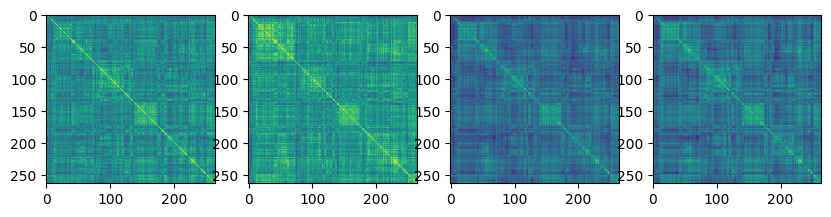

In [124]:
# Reconstruct static FC from dynamic FC

import matplotlib.pyplot as plt

sub = 200

dynfc = get_sub_fc(x[suborder[sub]])
dynfc = torch.mean(dynfc, dim=-1).detach().cpu().numpy()

statfc = np.corrcoef(ts[0][suborder[sub]])

reconfc = lrw(sub, book)
reconfc = torch.mean(reconfc, dim=-1).detach().cpu().numpy()

A = book.reshape(book.shape[0], -1).permute(1,0)
reconfc2 = torch.mean(A.cpu()@codes[suborder[sub]].cpu(), dim=1).reshape(264,264).detach().cpu().numpy()

fig, ax = plt.subplots(1,4,figsize=(10,3))

print(np.mean((statfc-124*dynfc)**2)**0.5)
print(np.mean((statfc-124*reconfc)**2)**0.5)
print(np.mean((statfc-124*reconfc2)**2)**0.5)

ax[0].imshow(dynfc)
ax[1].imshow(statfc)
ax[2].imshow(reconfc)
ax[3].imshow(reconfc2)
fig.show()

In [125]:
nreps = 10
trainsizes = [30,50,100,200,300,400,500,600,700,800]
res = np.zeros((nreps,len(trainsizes)))

for rep in range(nreps):
    dct = dict()
    for l2 in [1e-2]: #1e-3 good for age 1e-2 good for wrat
        losses = []

        idcs = np.arange(codes.shape[0])
        np.random.shuffle(idcs)

        for ntrain in trainsizes:
            codescuda = codes.float().cuda()
            xps = torch.mean(codescuda, dim=-1)
            xps = torch.cat([xps, torch.ones(xps.shape[0], 1).float().cuda()], dim=1)
            xtr = xps[idcs[:ntrain]]
            xt = xps[idcs[ntrain:]]

            y = get_y(metadict, ['age'], subs)[0]
            y_t = torch.from_numpy(y).float().cuda()
            ytr = y_t[idcs[:ntrain]]
            yt = y_t[idcs[ntrain:]]

            # REDUCE THIS TO GET GOOD RESULTS WITH SPARSITY 0.01->0.001 or 0.0001
            w, _, _, _ = torch.linalg.lstsq(xtr.T@xtr + l2*torch.eye(ncodes+1).float().cuda(), xtr.T@ytr)

        #     print(torch.mean((ytr-xtr@w)**2)**0.5)
            losses.append(float(torch.mean((yt-xt@w)**2)**0.5))
            
        dct[l2] = losses
    
    valmin = float('inf')
    valsav = None
    keysav = None
    
    for key,val in dct.items():
        this = np.mean(val[4:-1])
        if this < valmin:
            valsav = val
            valmin = this
            keysav = key
#     print(keysav)
    
    res[rep,:] = valsav
    
print(np.mean(res, axis=0))
print(np.std(res, axis=0))

[38.09110527 37.27643585 35.89479179 34.5914566  33.93579674 33.50535049
 32.58813572 32.08820858 32.23105164 31.95988903]
[1.44828901 1.241131   0.43254127 0.54604297 0.67821111 0.90194749
 0.76752532 0.56943666 1.70506429 2.51174095]


In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, ncodes):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(ncodes, 40).float().cuda()
        self.l2 = nn.Linear(40,1).float().cuda()
        
    def train(self, xtr, ytr, nepochs=1000, lr=1e-1, l1=1e-1, l2=1e-4, pperiod=100, verbose=False):
        optim = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.75, eps=1e-7)
        
        for epoch in range(nepochs):
            optim.zero_grad()
            yhat = self(xtr)
            loss = mseLoss(yhat, ytr)**0.5
            l1loss = l1*torch.sum(torch.abs(self.l1.weight))
            (loss+l1loss).backward()
            optim.step()
            sched.step(loss)
            if verbose:
                if epoch % pperiod == 0 or epoch == nepochs-1:
                    print(f'{epoch} {[float(l) for l in [loss, l1loss]]} {sched._last_lr}')
                    
    def predict(self, xt, yt):
        with torch.no_grad():
            return mseLoss(self(xt), yt)**0.5
                    
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x).squeeze()
        return x

nreps = 10
trainsizes = [30,50,100,200,300,400,500,600,700,800]
res = np.zeros((nreps,len(trainsizes)))

for rep in range(nreps):

    idcs = np.arange(codes.shape[0])
    np.random.shuffle(idcs)
    
    losses = []

    for ntrain in trainsizes:
        codescuda = codes.float().cuda()
        xps = torch.mean(codescuda, dim=-1)
        xtr = xps[idcs[:ntrain]]
        xt = xps[idcs[ntrain:]]

        y = get_y(metadict, ['age'], subs)[0]
        y_t = torch.from_numpy(y).float().cuda()
        ytr = y_t[idcs[:ntrain]]
        yt = y_t[idcs[ntrain:]]

        mlp = MLP(ncodes)
        # 1e-3 good for age 1e-2 good for wrat
        mlp.train(xtr, ytr, lr=1e-2, nepochs=1000, l1=1e-3, l2=1e-4)
        loss = mlp.predict(xt, yt)

        losses.append(float(loss))
        print(float(loss))
    
    res[rep,:] = losses
    print(f'Finished {rep}')
    
print(np.mean(res, axis=0))
print(np.std(res, axis=0))

42.597137451171875
42.726070404052734
39.532840728759766
36.11131286621094
35.020023345947266
34.77971649169922
33.27064514160156
33.487037658691406
31.713525772094727
26.475055694580078
Finished 0
39.494083404541016
40.8665771484375
36.498077392578125
34.83207321166992
35.54125213623047
35.0764045715332
36.113243103027344
36.104774475097656
36.37314224243164
39.78739547729492
Finished 1
42.48074722290039
42.69774627685547
37.882354736328125
36.05211639404297
35.80912780761719
35.835609436035156
33.982215881347656
35.50794219970703
36.65863037109375
36.691104888916016
Finished 2
41.610538482666016
40.5862922668457
39.363277435302734
37.1771125793457
35.61236572265625
34.78479766845703
35.64139938354492
33.912269592285156
36.46709060668945
38.48558807373047
Finished 3
41.376461029052734
41.315635681152344
39.74958801269531
35.06296157836914
33.765254974365234
33.232078552246094
33.34962844848633
34.91133499145508
34.112510681152344
41.78145217895508
Finished 4
39.35664367675781
40.01486

In [127]:
nreps = 10
trainsizes = [30,50,100,200,300,400,500,600,700,800]
res = np.zeros((nreps,len(trainsizes)))

nepochs = 500
pperiod = 100
verbose = False

for rep in range(nreps):

    idcs = np.arange(codes.shape[0])
    np.random.shuffle(idcs)
    
    losses = []

    for ntrain in trainsizes:
        codescuda = codes.float().cuda()
        xps = torch.mean(codescuda[idcs], dim=-1).unsqueeze(1)
        
        mu = torch.mean(xps[:ntrain], dim=0, keepdims=True)
        std = torch.std(xps[:ntrain], dim=0, keepdims=True)
        xps = (xps-mu)/std
    
        xtr = xps[:ntrain]
        xt = xps[ntrain:]

        y = get_y(metadict, ['age'], subs)[0]
        y_t = torch.from_numpy(y[idcs]).float().cuda()
        ytr = y_t[:ntrain]
        yt = y_t[ntrain:]

        # dp=0.5 for wrat
        sim = LatSim(1, xps, dp=0.5, edp=0.1, wInit=1e-4, dim=2, temp=1)
        optim = torch.optim.Adam(sim.parameters(), lr=1e-3, weight_decay=1e-3)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.75, eps=1e-7)
        
        for epoch in range(nepochs):
            optim.zero_grad()
            yhat = sim(xtr, [ytr])[0][0]
            loss = mseLoss(yhat, ytr)**0.5
            loss.backward()
            optim.step()
            sched.step(loss)
            if verbose:
                if epoch % pperiod == 0 or epoch == nepochs-1:
                    print(f'{epoch} {float(loss)} {sched._last_lr}')
                    
        sim.eval()
        yhat = sim(xps, [y_t], np.arange(ntrain,idcs.shape[0]))[0][0][ntrain:]
        loss = mseLoss(yhat, yt)**0.5
        losses.append(float(loss))
        
        print(float(loss))
    
    res[rep,:] = losses
    print(f'Finished {rep}')
    
print(np.mean(res, axis=0))
print(np.std(res, axis=0))

38.38093185424805
35.26548767089844
34.56732940673828
32.83502960205078
30.236249923706055
30.758386611938477
29.87166976928711
30.59238624572754
30.99720001220703
27.601436614990234
Finished 0
42.018531799316406
40.35102081298828
36.465492248535156
34.433265686035156
32.874935150146484
31.191936492919922
31.40182113647461
31.126745223999023
29.948734283447266
30.362337112426758
Finished 1
38.11109161376953
35.99375915527344
35.66242218017578
33.70657730102539
31.154523849487305
31.2867431640625
31.425521850585938
29.68239974975586
28.410402297973633
36.61967849731445
Finished 2
41.15867614746094
38.384132385253906
36.2861328125
32.948699951171875
31.720352172851562
30.3006649017334
31.616188049316406
31.71542739868164
30.592727661132812
31.053720474243164
Finished 3
35.119083404541016
34.95315170288086
35.33298110961914
32.923492431640625
31.885108947753906
30.87137794494629
30.487041473388672
29.166967391967773
27.037630081176758
29.6748104095459
Finished 4
36.475460052490234
35.4752